STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Inspecting the Latent Space Distribution

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.1+cu111



## Imports

In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [3]:
from helper_data import get_dataloaders_celeba

In [4]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
BATCH_SIZE = 5000

Device: cuda:1


## Dataset

In [5]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

Files already downloaded and verified


## Model

In [6]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

### Load Model

In [7]:
model = VAE()
model.load_state_dict(torch.load('vae_celeba_02.pt', map_location=torch.device('cpu')))
model.to(DEVICE);

## Inspect Latent Dimensions

In [8]:
# Limit to 10k images

all_embeddings = torch.zeros((10_000, 200))

num_images = 0
for images, labels in train_loader:
    
    if num_images >= 10_000:
        break
    
    begin = num_images
    end = begin + images.size(0)
    
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    with torch.no_grad():
        embeddings = model.encoding_fn(images).to('cpu')
        
    all_embeddings[begin:end] = embeddings
    
    num_images = end

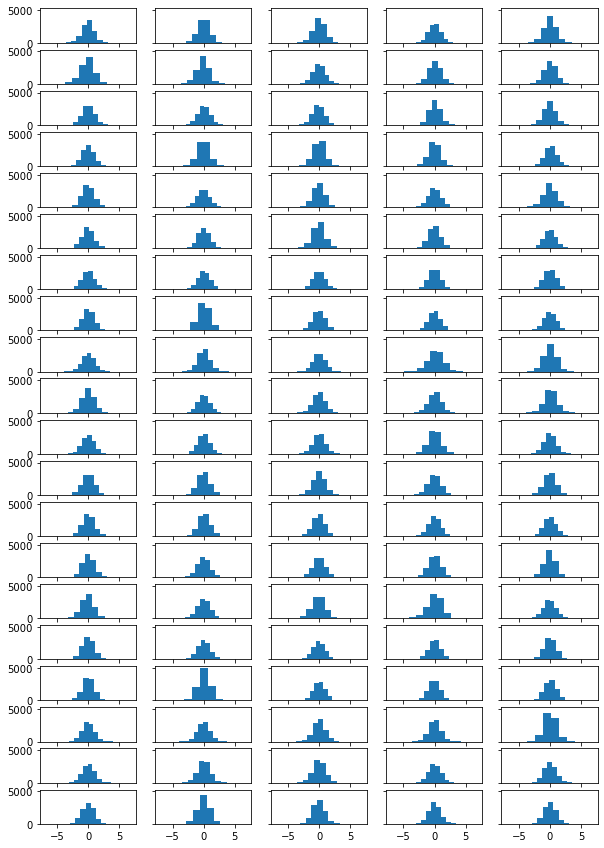

In [9]:
fig, axes = plt.subplots(nrows=20, ncols=5, 
                         sharex=True, sharey=True,
                         figsize=(10, 15))
    
i = 0
for row in range(len(axes)):
    for col in range(len(axes[0])):
        axes[row][col].hist(all_embeddings[:, i].numpy())
        i += 1

plt.show()